<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [294]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [295]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-02 22:35:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-06-02 22:35:48 (9.95 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [296]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [297]:
df.shape

(346, 10)

### Convert to date time object 

In [298]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [299]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [300]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



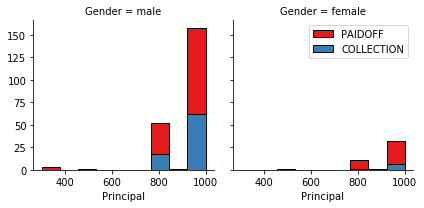

In [301]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

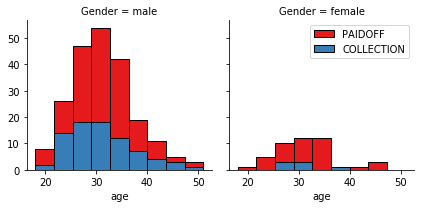

In [302]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

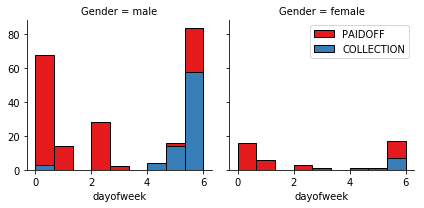

In [303]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [304]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [305]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [306]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [307]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [308]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [309]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [310]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [311]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [312]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [313]:
# to fix Type Error for Accuracy Testing
df['loan_status'].replace(to_replace = ["PAIDOFF", "COLLECTION"], value = [0, 1], inplace = True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [314]:
y_train = df['loan_status'].values
y_train[0:5]

array([0, 0, 0, 0, 0])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [315]:
# import all tools
from scipy.stats import randint
from numpy import array
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn import metrics

In [316]:
parameters = {"algorithm": ["kd_tree"], "leaf_size": np.arange(5, 100, 5), "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"], "n_neighbors": np.arange(1, 9), "p": np.arange(1, 2)}
knn = KNeighborsClassifier()
knn_cv = RandomizedSearchCV(knn, parameters, cv = 10)
knn_cv.fit(X, y_train)
print("Tuned k-NN Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned k-NN Parameters: {'p': 1, 'n_neighbors': 8, 'metric': 'euclidean', 'leaf_size': 85, 'algorithm': 'kd_tree'}
Best score is 0.7456647398843931


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [317]:
NN = knn_cv.best_params_["n_neighbors"]
NN

8

# Decision Tree

In [318]:
parameters = {"criterion": ["gini", "entropy"], "splitter": ["best", "random"], "max_depth": np.arange(1, 10), 
              "min_samples_leaf": np.arange(1, 10), "max_features": ["auto", "sqrt", "log2", None], "min_impurity_decrease": [0.0]}

In [319]:
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv = 10)
tree_cv.fit(X, y_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'splitter': 'best'}
Best score is 0.7630057803468208


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Support Vector Machine

In [320]:
parameters = {"C": np.arange(0.1, 1.0, 0.1), "kernel": ["linear", "poly", "rbf", "sigmoid"], "degree": np.arange(1, 5), "gamma": ["scale", "auto"], "max_iter": [-1], "decision_function_shape": ["ovo", "ovr"]}

In [321]:
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv = 10)
svm_cv.fit(X, y_train)

print("Tuned Suport Vector Machine Parameters: {}".format(svm_cv.best_params_))
print("Best score is {}".format(svm_cv.best_score_))

Tuned Suport Vector Machine Parameters: {'C': 0.2, 'decision_function_shape': 'ovo', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1}
Best score is 0.7543352601156069


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Logistic Regression

In [322]:
parameters = {"penalty": ["l1","l2"], "C": [0.001, 0.01, 0.1, 1, 10], "fit_intercept": [True], "solver": ["liblinear", "saga"]}

In [323]:
reg = LogisticRegression()
reg_cv = RandomizedSearchCV(reg, parameters, cv = 10)
reg_cv.fit(X, y_train)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The ma

Tuned Linear Regression Parameters: {'solver': 'saga', 'penalty': 'l2', 'fit_intercept': True, 'C': 0.01}
Best score is 0.7514450867052023


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Model Evaluation using Test set

In [324]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [325]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-02 22:39:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-02 22:39:19 (242 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [326]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [327]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
Unnamed: 0        54 non-null int64
Unnamed: 0.1      54 non-null int64
loan_status       54 non-null object
Principal         54 non-null int64
terms             54 non-null int64
effective_date    54 non-null object
due_date          54 non-null object
age               54 non-null int64
education         54 non-null object
Gender            54 non-null object
dtypes: int64(5), object(5)
memory usage: 4.3+ KB


In [328]:
test_df['loan_status'].replace(to_replace = ["PAIDOFF", "COLLECTION"], value = [0, 1], inplace = True)
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30       9/8/2016   
1            5             5            0        300      7       9/9/2016   
2           21            21            0       1000     30      9/10/2016   
3           24            24            0       1000     30      9/10/2016   
4           35            35            0        800     15      9/11/2016   
5           37            37            0        700     15      9/11/2016   
6           38            38            0       1000     15      9/11/2016   
7           48            48            0       1000     30      9/11/2016   
8           50            50            0        800     15      9/11/2016   
9           61            61            0       1000     15      9/11/2016   
10          64            64            0        800     15      9/11/2016   
11          68            68            0        300      7     

In [329]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30       9/8/2016   
1            5             5            0        300      7       9/9/2016   
2           21            21            0       1000     30      9/10/2016   
3           24            24            0       1000     30      9/10/2016   
4           35            35            0        800     15      9/11/2016   
5           37            37            0        700     15      9/11/2016   
6           38            38            0       1000     15      9/11/2016   
7           48            48            0       1000     30      9/11/2016   
8           50            50            0        800     15      9/11/2016   
9           61            61            0       1000     15      9/11/2016   
10          64            64            0        800     15      9/11/2016   
11          68            68            0        300      7     

In [330]:
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30     2016-09-08   
1            5             5            0        300      7     2016-09-08   
2           21            21            0       1000     30     2016-09-08   
3           24            24            0       1000     30     2016-09-09   
4           35            35            0        800     15     2016-09-09   
5           37            37            0        700     15     2016-09-09   
6           38            38            0       1000     15     2016-09-09   
7           48            48            0       1000     30     2016-09-10   
8           50            50            0        800     15     2016-09-10   
9           61            61            0       1000     15     2016-09-10   
10          64            64            0        800     15     2016-09-10   
11          68            68            0        300      7     

In [331]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30     2016-09-08   
1            5             5            0        300      7     2016-09-08   
2           21            21            0       1000     30     2016-09-08   
3           24            24            0       1000     30     2016-09-09   
4           35            35            0        800     15     2016-09-09   
5           37            37            0        700     15     2016-09-09   
6           38            38            0       1000     15     2016-09-09   
7           48            48            0       1000     30     2016-09-10   
8           50            50            0        800     15     2016-09-10   
9           61            61            0       1000     15     2016-09-10   
10          64            64            0        800     15     2016-09-10   
11          68            68            0        300      7     

In [332]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30     2016-09-08   
1            5             5            0        300      7     2016-09-08   
2           21            21            0       1000     30     2016-09-08   
3           24            24            0       1000     30     2016-09-09   
4           35            35            0        800     15     2016-09-09   
5           37            37            0        700     15     2016-09-09   
6           38            38            0       1000     15     2016-09-09   
7           48            48            0       1000     30     2016-09-10   
8           50            50            0        800     15     2016-09-10   
9           61            61            0       1000     15     2016-09-10   
10          64            64            0        800     15     2016-09-10   
11          68            68            0        300      7     

In [333]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
print(test_df)

    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0            1             1            0       1000     30     2016-09-08   
1            5             5            0        300      7     2016-09-08   
2           21            21            0       1000     30     2016-09-08   
3           24            24            0       1000     30     2016-09-09   
4           35            35            0        800     15     2016-09-09   
5           37            37            0        700     15     2016-09-09   
6           38            38            0       1000     15     2016-09-09   
7           48            48            0       1000     30     2016-09-10   
8           50            50            0        800     15     2016-09-10   
9           61            61            0       1000     15     2016-09-10   
10          64            64            0        800     15     2016-09-10   
11          68            68            0        300      7     

In [334]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
print(Feature)

    Principal  terms  age  Gender  weekend
0        1000     30   50       1        0
1         300      7   35       0        0
2        1000     30   43       1        0
3        1000     30   26       0        1
4         800     15   29       0        1
5         700     15   33       0        1
6        1000     15   24       0        1
7        1000     30   32       0        1
8         800     15   27       1        1
9        1000     15   37       0        1
10        800     15   24       0        1
11        300      7   35       0        1
12       1000     30   31       0        1
13       1000     30   37       1        1
14       1000     30   37       1        1
15       1000     30   33       0        1
16        800     15   43       0        1
17       1000      7   32       1        1
18       1000     15   26       0        1
19       1000      7   29       0        1
20       1000     30   30       0        1
21       1000      7   27       0        1
22        3

In [335]:
Feature.dropna()
print(Feature)

    Principal  terms  age  Gender  weekend
0        1000     30   50       1        0
1         300      7   35       0        0
2        1000     30   43       1        0
3        1000     30   26       0        1
4         800     15   29       0        1
5         700     15   33       0        1
6        1000     15   24       0        1
7        1000     30   32       0        1
8         800     15   27       1        1
9        1000     15   37       0        1
10        800     15   24       0        1
11        300      7   35       0        1
12       1000     30   31       0        1
13       1000     30   37       1        1
14       1000     30   37       1        1
15       1000     30   33       0        1
16        800     15   43       0        1
17       1000      7   32       1        1
18       1000     15   26       0        1
19       1000      7   29       0        1
20       1000     30   30       0        1
21       1000      7   27       0        1
22        3

In [336]:
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
print(Feature)

    Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0        1000     30   50       1        0         1                     0   
1         300      7   35       0        0         0                     0   
2        1000     30   43       1        0         0                     1   
3        1000     30   26       0        1         0                     0   
4         800     15   29       0        1         1                     0   
5         700     15   33       0        1         0                     1   
6        1000     15   24       0        1         0                     0   
7        1000     30   32       0        1         1                     0   
8         800     15   27       1        1         0                     0   
9        1000     15   37       0        1         0                     0   
10        800     15   24       0        1         0                     1   
11        300      7   35       0        1         0            

In [337]:
Feature.rename(columns = {'Bechalor' : "Bachelor"}, inplace = True)
print(Feature)

    Principal  terms  age  Gender  weekend  Bachelor  High School or Below  \
0        1000     30   50       1        0         1                     0   
1         300      7   35       0        0         0                     0   
2        1000     30   43       1        0         0                     1   
3        1000     30   26       0        1         0                     0   
4         800     15   29       0        1         1                     0   
5         700     15   33       0        1         0                     1   
6        1000     15   24       0        1         0                     0   
7        1000     30   32       0        1         1                     0   
8         800     15   27       1        1         0                     0   
9        1000     15   37       0        1         0                     0   
10        800     15   24       0        1         0                     1   
11        300      7   35       0        1         0            

In [338]:
Feature.drop(['Master or Above'], axis = 1, inplace=True)
print(Feature)

    Principal  terms  age  Gender  weekend  Bachelor  High School or Below  \
0        1000     30   50       1        0         1                     0   
1         300      7   35       0        0         0                     0   
2        1000     30   43       1        0         0                     1   
3        1000     30   26       0        1         0                     0   
4         800     15   29       0        1         1                     0   
5         700     15   33       0        1         0                     1   
6        1000     15   24       0        1         0                     0   
7        1000     30   32       0        1         1                     0   
8         800     15   27       1        1         0                     0   
9        1000     15   37       0        1         0                     0   
10        800     15   24       0        1         0                     1   
11        300      7   35       0        1         0            

In [339]:
X_test = Feature
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [340]:
Y_test = test_df['loan_status'].values
Y_test[0:5]

array([0, 0, 0, 0, 0])

 # Accuracy Test

## KNN

In [341]:
train_accuracy = knn_cv.score(X, y_train)
train_accuracy

0.7976878612716763

In [342]:
test_accuracy = knn_cv.score(X_test, Y_test)
test_accuracy

0.7407407407407407

In [343]:
y_pred = knn_cv.predict(X_test)
print(confusion_matrix(Y_test, y_pred))
print()
print(classification_report(Y_test, y_pred))

[[40  0]
 [14  0]]

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        40
           1       0.00      0.00      0.00        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [344]:
fs1 = f1_score(Y_test, y_pred, average='weighted')
fs1

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6304176516942475

In [345]:
y_pred_p = knn_cv.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(Y_test, y_pred_p)))

AUC: 0.5125


In [346]:
cv_auc = cross_val_score(knn_cv, X_test, Y_test, cv = 10, scoring = "roc_auc")
print("AUC scores computed using 10-fold cross validation: {}".format(cv_auc))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/mod

AUC scores computed using 10-fold cross validation: [0.8125 0.25   0.3125 0.     0.375  0.25   0.625  0.625  1.     0.625 ]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


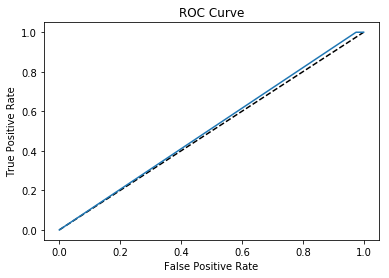

In [347]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_p)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [348]:
from sklearn.metrics import jaccard_similarity_score
js1 = jaccard_similarity_score(Y_test, y_pred)
js1

0.7407407407407407

In [349]:
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = k)
    print(knn)
    knn.fit(X, y_train)
    train_accuracy[i] = knn.score(X, y_train)
    test_accuracy[i] = knn.score(X_test, Y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform'

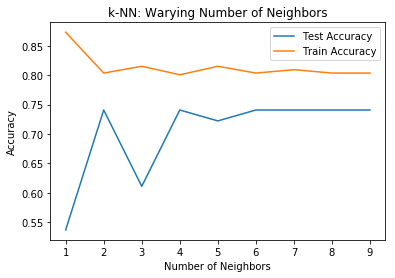

In [350]:
plt.title("k-NN: Warying Number of Neighbors")
plt.plot(neighbors, test_accuracy, label = "Test Accuracy")
plt.plot(neighbors, train_accuracy, label = "Train Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

## Decision Tree

In [351]:
train_accuracy = tree_cv.score(X, y_train)
train_accuracy

0.7514450867052023

In [352]:
test_accuracy = tree_cv.score(X_test, Y_test)
test_accuracy

0.7407407407407407

In [353]:
y_pred = tree_cv.predict(X_test)
print(confusion_matrix(Y_test, y_pred))
print()
print(classification_report(Y_test, y_pred))

[[40  0]
 [14  0]]

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        40
           1       0.00      0.00      0.00        14

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [354]:
fs2 = f1_score(Y_test, y_pred, average='weighted')
fs2

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6304176516942475

In [355]:
y_pred_p = tree_cv.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(Y_test, y_pred_p)))

cv_auc = cross_val_score(tree_cv, X_test, Y_test, cv = 10, scoring = "roc_auc")
print("AUC scores computed using 10-fold cross validation: {}".format(cv_auc))

AUC: 0.5946428571428571


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/mod

AUC scores computed using 10-fold cross validation: [0.5625 0.625  0.4375 0.8125 0.125  1.     0.875  0.125  0.875  0.75  ]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


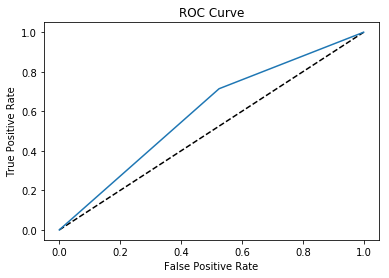

In [356]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_p)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [357]:
js2 = jaccard_similarity_score(Y_test, y_pred)
js2

0.7407407407407407

## Support Vector Machine

In [358]:
train_accuracy = svm_cv.score(X, y_train)
train_accuracy

0.7601156069364162

In [359]:
test_accuracy = svm_cv.score(X_test, Y_test)
test_accuracy

0.6666666666666666

In [360]:
y_pred = svm_cv.predict(X_test)
print(confusion_matrix(Y_test, y_pred))
print()
print(classification_report(Y_test, y_pred))

[[35  5]
 [13  1]]

              precision    recall  f1-score   support

           0       0.73      0.88      0.80        40
           1       0.17      0.07      0.10        14

   micro avg       0.67      0.67      0.67        54
   macro avg       0.45      0.47      0.45        54
weighted avg       0.58      0.67      0.62        54



In [361]:
fs3 = f1_score(Y_test, y_pred, average='weighted')
print (fs3)

0.6151515151515151


In [362]:
js3 = jaccard_similarity_score(Y_test, y_pred)
print(js3)

0.6666666666666666


## Logistic Regression

In [363]:
train_accuracy = reg_cv.score(X, y_train)
train_accuracy

0.7514450867052023

In [364]:
test_accuracy = reg_cv.score(X_test, Y_test)
test_accuracy

0.25925925925925924

In [365]:
y_pred = reg_cv.predict(X_test)
print(confusion_matrix(Y_test, y_pred))
print()
print(classification_report(Y_test, y_pred))


[[ 0 40]
 [ 0 14]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.26      1.00      0.41        14

   micro avg       0.26      0.26      0.26        54
   macro avg       0.13      0.50      0.21        54
weighted avg       0.07      0.26      0.11        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [366]:
fs4 = f1_score(Y_test, y_pred, average='weighted')
fs4

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.10675381263616558

In [367]:
y_pred_p = reg_cv.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(Y_test, y_pred_p)))

cv_auc = cross_val_score(reg_cv, X_test, Y_test, cv = 10, scoring = "roc_auc")
print("AUC scores computed using 10-fold cross validation: {}".format(cv_auc))

AUC: 0.45089285714285715


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The ma

AUC scores computed using 10-fold cross validation: [0.5   0.375 0.375 0.75  1.    0.    0.5   0.25  0.25  0.25 ]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


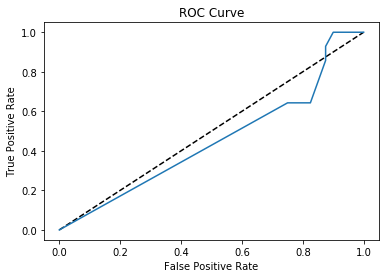

In [368]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_p)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [369]:
js4 = jaccard_similarity_score(Y_test, y_pred)
js4

0.25925925925925924

In [370]:
ll4 = log_loss(Y_test, y_pred_proba)
ll4

0.6105847152233901

In [371]:
list_results_jc =  [js1, js2, js3, js4]
list_results_fs = [fs1, fs2, fs3, fs4]
list_results_ll = ['NA','NA','NA', ll4]

In [372]:
df = pd.DataFrame(list_results_jc, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_results_fs)
df.insert(loc=2, column='LogLoss', value=list_results_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.740741,0.630418,NA
Decision Tree,0.740741,0.630418,NA
SVM,0.666667,0.615152,NA
Logistic Regression,0.259259,0.106754,0.610585


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>